In [7]:
# Cell 1: Install required packages
"""
Install necessary Python packages:
- fredapi: For accessing Federal Reserve Economic Data
- pandas: For data manipulation
- matplotlib and seaborn: For data visualization
- scikit-learn: For machine learning models
"""
!pip install fredapi pandas matplotlib seaborn scikit-learn



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Cell 2: Import required libraries
"""
Import necessary libraries:
- pandas: For dataframe operations
- matplotlib/seaborn: For plotting
- fredapi: For accessing FRED data
- sklearn: For machine learning functionality
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Cell 3: Initialize FRED API
"""
Create FRED API instance with authentication key
Note: API key should ideally be stored in environment variables
"""
fred = Fred(api_key='90189794de39522c491ae23c713310c0') 

In [10]:
# Cell 4: Define and fetch economic indicators
"""
Create dictionary of economic indicators and their FRED codes
Fetch data for each indicator from 2003-2023
Convert dates and create individual dataframes
"""
series_dict = {
    'CSUSHPISA': 'HomePriceIndex',
    'MORTGAGE30US': 'MortgageRate',
    'UNRATE': 'UnemploymentRate',
    'GS10': 'TreasuryYield',
    'GDP': 'GDP',
    'MEHOINUSA672N': 'MedianIncome',
    'CPIAUCSL': 'CPI',
    'HOUST': 'HousingStarts',
    'POP': 'Population'
}

data_frames = []

for code, name in series_dict.items():
    data = fred.get_series(code)
    df = data.reset_index()
    df.columns = ['DATE', name]
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df[(df['DATE'] >= '2003-01-01') & (df['DATE'] <= '2023-12-31')]
    data_frames.append(df)

In [11]:
# Cell 5: Merge datasets
"""
Combine all individual datasets into one dataframe
Handle missing values and ensure chronological order
"""
from functools import reduce

df_merged = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), data_frames)
df_merged.sort_values('DATE', inplace=True)
df_merged = df_merged.fillna(method='ffill')  # Fill forward
df_merged = df_merged.dropna()  # Drop rows with any missing values

C:\Users\prith\AppData\Local\Temp\ipykernel_18444\1323699603.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged = df_merged.fillna(method='ffill')  # Fill forward


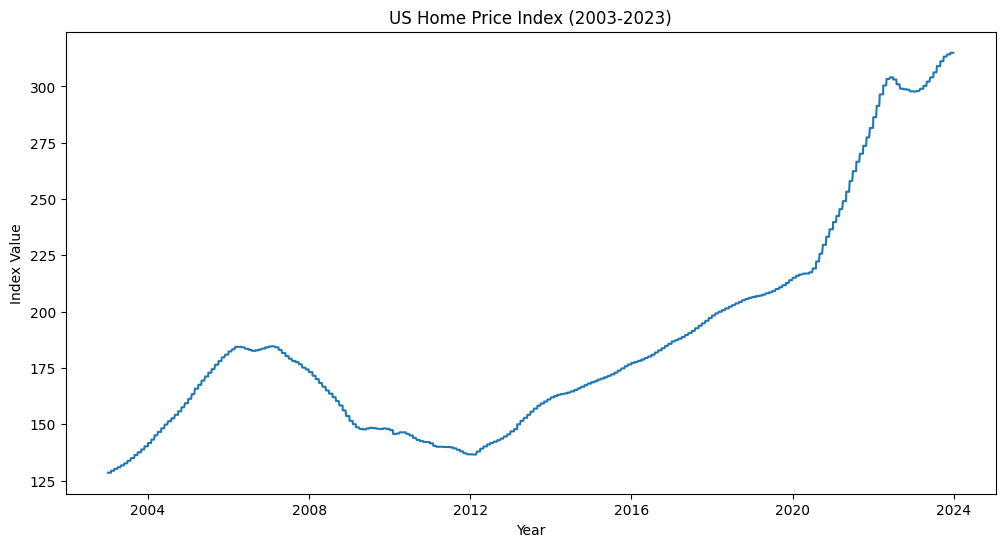

In [12]:
# Cell 6: Visualize Home Price Index
"""
Create time series plot of Home Price Index
Shows trend from 2003 to 2023
"""
plt.figure(figsize=(12, 6))
sns.lineplot(x='DATE', y='HomePriceIndex', data=df_merged)
plt.title("US Home Price Index (2003-2023)")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.show()

In [13]:
# Cell 7: Prepare features and target
"""
Separate features (X) and target variable (y)
Remove DATE column as it's not used for prediction
"""
X = df_merged.drop(columns=['DATE', 'HomePriceIndex'])
y = df_merged['HomePriceIndex']


In [14]:
# Cell 8: Split data for training
"""
Split data into training (80%) and test (20%) sets
Note: Random split may not be ideal for time series data
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Cell 9: Train Linear Regression model
"""
Initialize and train basic linear regression model
First attempt at modeling relationship
"""
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Cell 10: Scale features
"""
Standardize features to have mean=0 and variance=1
Important for fair comparison of feature importance
"""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Cell 11: Train Random Forest model
"""
Initialize and train Random Forest model
More complex model that can capture non-linear relationships
"""
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
# Cell 12: Hyperparameter tuning
"""
Use GridSearchCV to find optimal Random Forest parameters
Test different combinations of:
- Number of trees
- Tree depth
- Minimum samples for split
"""
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [19]:
# Cell 13: Cross-validation
"""
Perform 5-fold cross-validation
Evaluate model performance across different data splits
"""
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Mean R² Score:", scores.mean())

Cross-Validation R² Scores: [ 0.15396809  0.56507507 -0.40608904  0.90903816 -3.65614922]
Mean R² Score: -0.4868313880928876


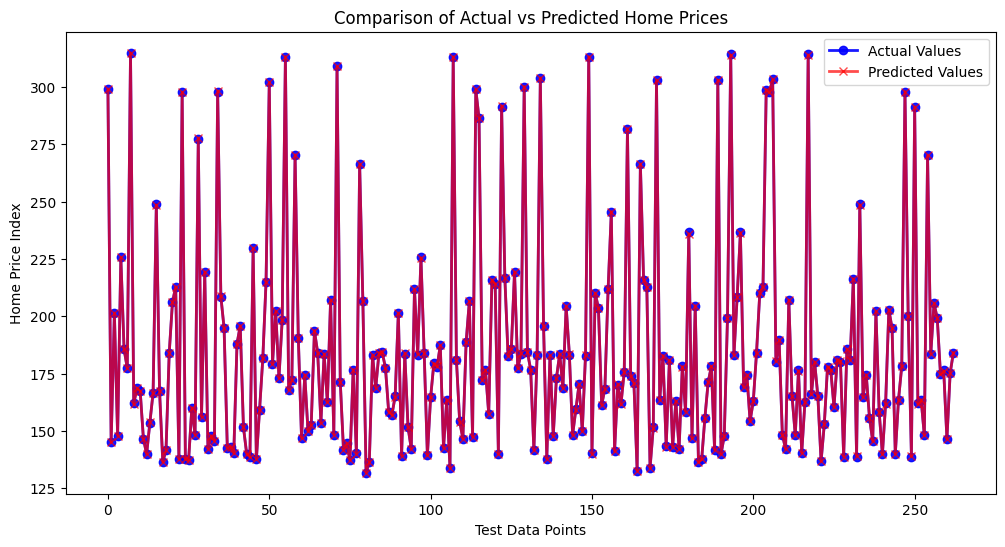

In [20]:
# Cell 14: Visualize predictions
"""
Create comparison plot of actual vs predicted values
Visual assessment of model performance
"""
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test.values, label="Actual Values", color="blue", alpha=0.9, linewidth=2, marker='o')

# Plot predicted values
plt.plot(y_pred, label="Predicted Values", color="red", alpha=0.7, linewidth=2, marker='x')

# Add title and labels
plt.title("Comparison of Actual vs Predicted Home Prices")
plt.xlabel("Test Data Points")
plt.ylabel("Home Price Index")
plt.legend()

# Show the plot
plt.show()

In [21]:
# Cell 15: Handle outliers
"""
Remove extreme values using z-score method
Keep only data points within 3 standard deviations
"""
from scipy.stats import zscore

df_merged['zscore'] = zscore(df_merged['HomePriceIndex'])
df_merged = df_merged[df_merged['zscore'].abs() < 3]  # Keep rows with z-score < 3
df_merged.drop(columns=['zscore'], inplace=True)

In [22]:
# Cell 16: Add lagged features
"""
Create lagged version of mortgage rate
Capture time-delayed effects on home prices
"""
df_merged['MortgageRate_Lag1'] = df_merged['MortgageRate'].shift(1)
df_merged.dropna(inplace=True)

In [23]:
# Cell 17: Analyze feature importance
"""
Calculate and display importance of each feature
Shows which factors most influence home prices
"""
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(coeff_df)

            Feature  Importance
5               CPI    0.325070
7        Population    0.299082
3               GDP    0.197781
4      MedianIncome    0.148934
1  UnemploymentRate    0.026395
2     TreasuryYield    0.001939
0      MortgageRate    0.000411
6     HousingStarts    0.000388


In [24]:
# Cell 18: Calculate final metrics
"""
Compute final model performance metrics
R² Score: Proportion of variance explained
MSE: Average squared prediction error
"""
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R² Score:", r2)
print("Mean Squared Error (MSE):", mse)

R² Score: 0.9999938744711383
Mean Squared Error (MSE): 0.013249966542965091


In [25]:
# Cell 19: Save results
"""
Export processed dataset and feature importance
Save results for further analysis or reporting
"""
df_merged.to_csv("final_dataset.csv", index=False)
coeff_df.to_csv("feature_impact.csv", index=False)